In [3]:
import pandas as pd
import ipywidgets as widgets
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from prophet import Prophet
import seaborn as sns

class ClimateData:
    
    # Initialize the class with input files and process the data
    def __init__(self, emissions_csv, con_temp_csv, sea_temp_csv, sea_level_csv):       
        emissions = pd.read_csv(emissions_csv)
        con_temp = pd.read_csv(con_temp_csv)
        sea_temp = pd.read_csv(sea_temp_csv)
        sea_level = pd.read_csv(sea_level_csv)
        self.df, self.global_df = self.clean_data(emissions, con_temp)
        self.sea_level = sea_level
        self.sea_temp = sea_temp
        self.global_cc = self.prepare_global_cc_data()
        
    # Clean and merge the emissions and con_temp dataframes
    def clean_data(self, emissions, con_temp):
        emissions.drop(emissions.columns[[1, 2, 3, 4, 5]], axis=1, inplace=True)
        emissions.replace(to_replace='World', value='Global', inplace=True)
        emissions = pd.melt(emissions, id_vars=['Country'], var_name='Year', value_name='Value')
        emissions.sort_values(by=['Country', 'Year'], ascending=True, inplace=True)
        emissions.rename(columns={'Value': 'Total_emissions'}, inplace=True)
        emissions['Country'].replace({'Republic of Korea': 'South Korea',
                                      'Russian Federation': 'Russia',
                                      'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
                                      'United States': 'USA',
                                      'United States of America': 'USA',
                                      'United Republic of Tanzania':'Tanzania',
                                      'Bolivia (Plurinational State of)':'Bolivia',
                                      'Iran (Islamic Republic of)': 'Iran',
                                      'Viet Nam': 'Vietnam'}, inplace=True)
        con_temp = con_temp.iloc[:, [3, 9, 11]]
        con_temp.rename(columns={'Area': 'Country'}, inplace=True)
        con_temp.rename(columns={'Value': 'Temp_change'}, inplace=True)
        con_temp['Country'].replace({'Republic of Korea': 'South Korea',
                                      'Russian Federation': 'Russia',
                                      'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
                                      'United States': 'USA',
                                      'United States of America': 'USA',
                                      'United Republic of Tanzania':'Tanzania',
                                      'Bolivia (Plurinational State of)':'Bolivia',
                                      'Iran (Islamic Republic of)': 'Iran',
                                      'Viet Nam': 'Vietnam'}, inplace=True)
        emissions['Year'] = pd.to_datetime(emissions['Year'], format='%Y').dt.year
        data = pd.merge(emissions, con_temp, on=['Country', 'Year'], how='inner')
        global_df = emissions[emissions['Country'] == 'Global']
        return data, global_df
    
    # Prepare the global climate change data by merging sea_level, sea_temp, global_df, and global_temp_change
    def prepare_global_cc_data(self):
        self.sea_level.drop(self.sea_level.columns[[1, 2, 3]], axis=1, inplace=True)
        self.sea_level = self.sea_level[(self.sea_level['Year'] >= 1990) & (self.sea_level['Year'] <= 2018)]
        self.sea_level.rename(columns={'NOAA - Adjusted sea level (inches)': 'Sea_level'}, inplace=True)
        self.sea_temp = self.sea_temp[(self.sea_temp['Year'] >= 1990) & (self.sea_temp['Year'] <= 2018)]
        self.sea_temp.rename(columns={'Annual anomaly': 'Sea_temp_anomaly'}, inplace=True)
        global_temp_change = self.df.groupby("Year")["Temp_change"].mean().reset_index()
        global_temp_change.rename(columns={"Temp_change": "Global_temp_change"}, inplace=True)
        global_cc = (
            self.sea_level.merge(self.sea_temp, on="Year", how="outer")
            .merge(self.global_df, on="Year", how="outer")
            .merge(global_temp_change, on="Year", how="outer")
        )
        global_cc.drop("Country", axis=1, inplace=True)
        corr = global_cc.drop('Year', axis=1).corr()
       # Create heatmap
        sns.set(style="white")
        sns.heatmap(corr, cmap="coolwarm", annot=True)
        plt.title('Correlation between Global Climate Change Variables')
        plt.show()
        return global_cc
    
    # Plot the top countries by emissions
    def update_top_emissions(self, countries):
        fig = go.Figure()
        for country in countries:
            country_df = self.df[self.df['Country'] == country]
            fig.add_trace(go.Scatter(x=country_df['Year'], y=country_df['Total_emissions'], mode='lines', name=country))
        fig.update_layout(title='Top 5 Countries by Emissions', xaxis_title='Year', yaxis_title='Total Emissions', template='plotly_dark')
        fig.show()
        
     # Plot the top countries by temperature change
    def update_top_temp_change(self, countries):
        fig = go.Figure()
        for country in countries:
            country_df = self.df[self.df['Country'] == country]
            fig.add_trace(go.Scatter(x=country_df['Year'], y=country_df['Temp_change'], mode='lines', name=country))
        fig.update_layout(title='Top 10 Countries by Temperature Change', xaxis_title='Year', yaxis_title='Temperature Change', template='plotly_dark')
        fig.show()
        
    # Plot the total emissions for the selected country
    def update_country_emission(self, country):
        country_df = self.df[self.df['Country'] == country]
        fig = go.Figure(data=go.Scatter(x=country_df['Year'], y=country_df['Total_emissions'], mode='lines'))
        title = f'{country} : Total Emissions'
        fig.update_layout(title=title, xaxis_title='Year', yaxis_title='Total emissions', template='plotly_dark')
        fig.show()
        
    # Plot the temperature change for the selected country
    def update_country_temp_change(self, country):
        country_df = self.df[self.df['Country'] == country]
        fig = go.Figure(data=go.Scatter(x=country_df['Year'], y=country_df['Temp_change'], mode='lines'))
        title = f'{country} :Temperature Change'
        fig.update_layout(title=title, xaxis_title='Year', yaxis_title='Temperature Change', template='plotly_dark')
        fig.show()
        
    # Plot the temperature change for the selected country vs global total emissions
    def update_temp_emission(self, country):
        country_df = self.df[self.df['Country'] == country]    
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=country_df['Year'], y=country_df['Temp_change'], mode='lines', name='Temperature Change', yaxis='y'))
        fig.add_trace(go.Scatter(x=self.global_df['Year'], y=self.global_df['Total_emissions'], mode='lines', name='Global emissions', yaxis='y2'))
        fig.update_layout(title=f'{country}: Temperature Change vs Global Total Emissions', template='plotly_dark')
        fig.update_layout(xaxis_title='Year')
        fig.update_layout(yaxis_title='Temperature Change', yaxis=dict(titlefont=dict(color='#1f77b4')))
        fig.update_layout(yaxis2=dict(title='Total Emissions', overlaying='y', side='right', titlefont=dict(color='#ff7f0e')))
        fig.show()
        
    # Run the analysis and display the results using widgets    
    def run_analysis(self):
        top_5 = self.df.groupby('Country')['Total_emissions'].sum().sort_values(ascending=False).head(5).index.tolist()
        top_10 = self.df.groupby('Country')['Temp_change'].sum().sort_values(ascending=False).head(10).index.tolist()        
        self.update_top_temp_change(top_10)
        self.update_top_emissions(top_5)        
        dropdown_country = widgets.Dropdown(options=list(self.df['Country'].unique()), value='India', description='Country:')        
        widgets.interact(self.update_country_emission, country=dropdown_country)
        widgets.interact(self.update_country_temp_change, country=dropdown_country)
        widgets.interact(self.update_temp_emission, country=dropdown_country, global_df=widgets.fixed(self.global_df))
        
class ProphetTimeSeries:
    def __init__(self, input_df, target_column):
        self.input_df = input_df
        self.target_column = target_column
    
    def forecast(self, years_to_predict):
        # Create a copy of the input dataframe
        target_df = self.input_df.copy()        
        # Rename the columns to fit Prophet's naming convention
        target_df.rename(columns={"Year": "ds", self.target_column: "y"}, inplace=True)        
        # Instantiate the Prophet model
        model = Prophet()        
        # Add all the other columns as regressors
        for column_name in self.input_df.columns:
            if column_name != "Year" and column_name != self.target_column:
                model.add_regressor(column_name)        
        # Add the regressor values to the target_df
        for column_name in self.input_df.columns:
            if column_name != "Year":
                target_df[column_name] = self.input_df[column_name]        
        # Fit the model on the target_df
        model.fit(target_df)        
        # Create a new dataframe with future dates for the next n years
        future_years = pd.Series([year for year in range(self.input_df['Year'].max() + 1, self.input_df['Year'].max() + 1 + years_to_predict)])
        future = pd.DataFrame({"ds": future_years})        
        # Add the regressor values to the future dataframe
        for column_name in self.input_df.columns:
            if column_name != "Year":
                last_value = self.input_df[column_name].iloc[-1]
                future[column_name] = [last_value] * len(future)        
        # Predict the target variable
        forecast = model.predict(future)        
        # Extract the predicted values
        predicted_values = forecast["yhat"].values        
        # Add the predicted values to the original DataFrame
        predicted_years = [year for year in range(self.input_df['Year'].max() + 1, self.input_df['Year'].max() + 1 + years_to_predict)]
        predictions_df = pd.DataFrame({"Year": predicted_years, self.target_column: predicted_values})
        if self.target_column == "Global_temp_change":
            predictions_df.rename(columns={"Global_temp_change": "Global_temp_change (°C)"}, inplace=True)
        elif self.target_column == "Sea_level":
            predictions_df.rename(columns={"Sea_level": "Sea_level (inches)"}, inplace=True)           
        
        # Plot the predicted values
        fig = model.plot(forecast)
        plt.title("Predicted " + self.target_column + " (Prophet Model)")
        plt.xlabel("Year")
        plt.ylabel(self.target_column)
        plt.show()        
        print(predictions_df)

C:\Users\Vinee\anaconda3\lib\site-packages\pandas\core\frame.py:5034: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Vinee\anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



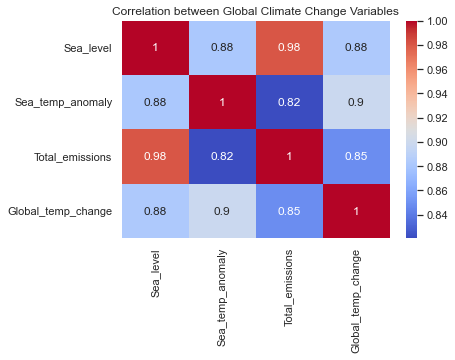

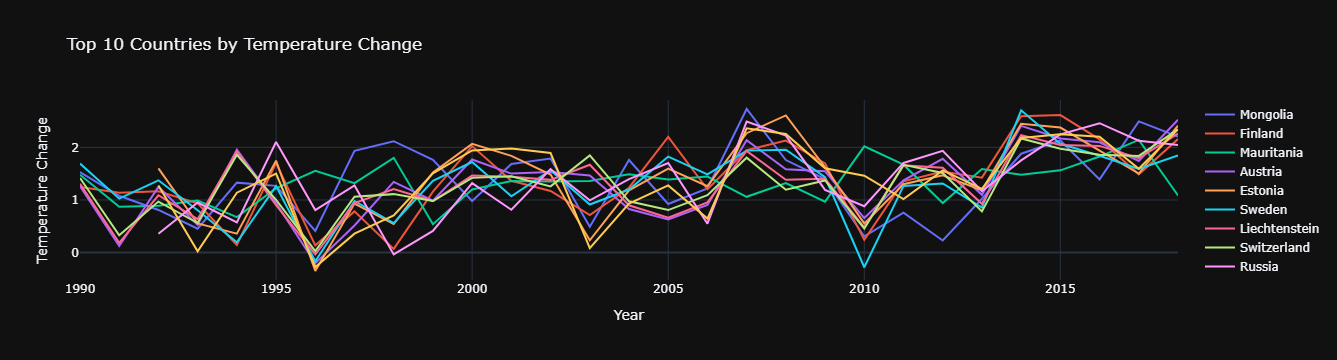

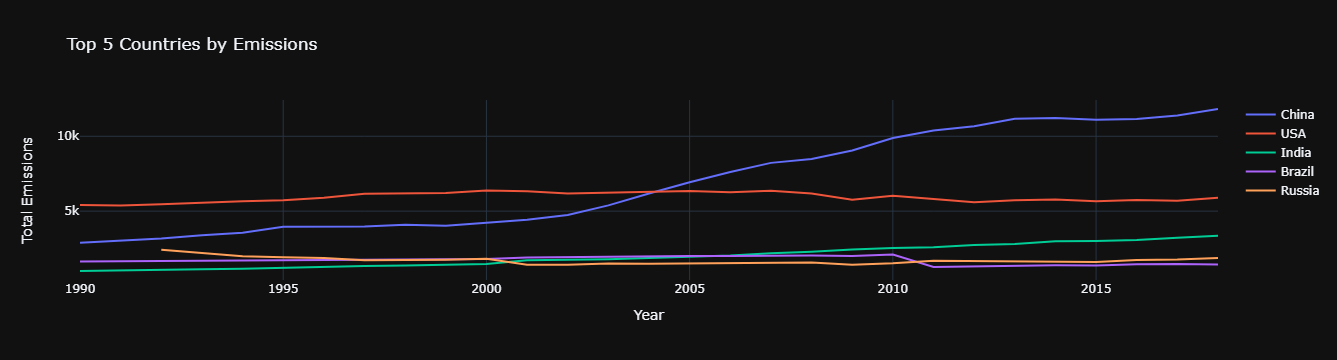

interactive(children=(Dropdown(description='Country:', index=72, options=('Afghanistan', 'Albania', 'Algeria',…

interactive(children=(Dropdown(description='Country:', index=72, options=('Afghanistan', 'Albania', 'Algeria',…

interactive(children=(Dropdown(description='Country:', index=72, options=('Afghanistan', 'Albania', 'Algeria',…

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.


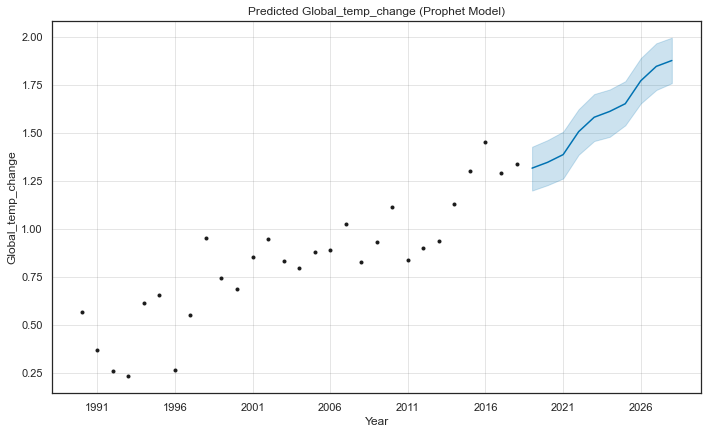

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.


   Year  Global_temp_change (°C)
0  2019                 1.315614
1  2020                 1.345933
2  2021                 1.386077
3  2022                 1.505561
4  2023                 1.580465
5  2024                 1.610784
6  2025                 1.650929
7  2026                 1.770412
8  2027                 1.845317
9  2028                 1.875635


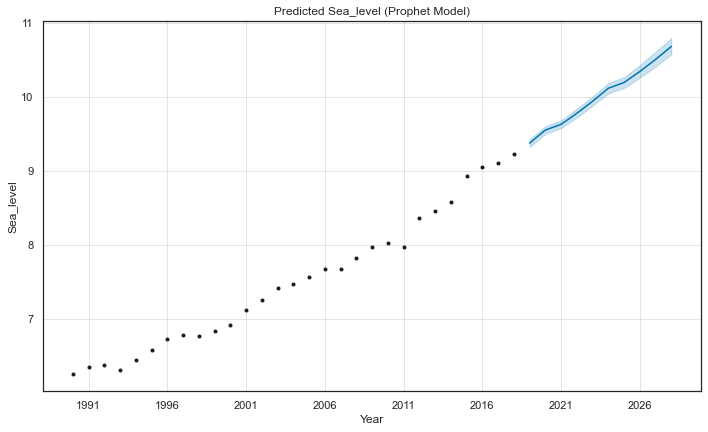

   Year  Sea_level (inches)
0  2019            9.375683
1  2020            9.551631
2  2021            9.629623
3  2022            9.778739
4  2023            9.941319
5  2024           10.117267
6  2025           10.195260
7  2026           10.344376
8  2027           10.506956
9  2028           10.682904


In [4]:
# Create an instance of the ClimateData class
climate_analysis = ClimateData('emissions.csv', 'country_temp.csv', 'sea_temp.csv', 'sea-level.csv')
# Call the run_analysis method
climate_analysis.run_analysis()
df = climate_analysis.df
global_df = climate_analysis.global_df
global_cc = climate_analysis.global_cc
# Create an instance of the ProphetTimeSeries class
temp_change = ProphetTimeSeries(global_cc, "Global_temp_change")
# Call the forecast method with the number of years to predict
temp_forecast = temp_change.forecast(10)
sea_level_change = ProphetTimeSeries(global_cc, "Sea_level")
# Call the forecast method with the number of years to predict
sea_level_forecast =sea_level_change.forecast(10)